In [8]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import numpy as np
import pandas as pd
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors 

In [78]:
df_data = pd.read_csv('data.csv', index_col=0).drop(columns=['Unnamed: 0'])
df_bac = pd.read_csv('bacterial_descriptors.csv', index_col=0)
df_drug = pd.read_csv('drug_descriptors.csv', index_col=0)

In [10]:
df_data.head(1)

,Bacteria,NP_Synthesis,Drug,Drug_class_drug_bank,Drug_dose,NP_concentration,NP size_min,NP size_max,NP size_avg,shape,method,ZOI_drug,ZOI_NP,ZOI_drug_NP,fold_increase_in_antibacterial_activity (%),MDR_check
0,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Amoxicillin,Lactams,NaN,NaN,4.0,10.0,8.0,spherical,MIC,32+,6.3,32+,NaN,1


In [11]:
df_bac.head(1)

,Bacteria,kingdom,subkingdom,clade,phylum,class,order,family,genus,species,gram,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,isolated_from
Tax_id,,,,,,,,,,,,,,,,,
['470'],Acinetobacter baumannii,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Moraxellales,Moraxellaceae,Acinetobacter,Acinetobacter calcoaceticus/baumannii complex,n,24.0,36.0,48.0,37,2,urine


In [12]:
df_drug.head(1)

,drug,chemID,prefered_name,smiles
0,Amoxicillin,CHEMBL1082,AMOXICILLIN,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...


# Работаем с драгами

In [79]:
df_drug.drop(columns=['prefered_name', 'chemID'], inplace=True)
df_drug.head(1)

,drug,smiles
0,Amoxicillin,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...


In [80]:
drugs_in_drugs = set(df_drug.drug.unique())
drugs_in_data = set(df_data.Drug.unique())
drugs_in_data.difference(drugs_in_drugs)

{'Neomycin', nan}

Неомицин добавим вручную, nan будем считать наночастицами без модификаций

In [81]:
# лень разбираться с апи pubchem, но нужно добавить неомицин
Neomycin = {
    'drug': ['neomycin'],
    'smiles': [
        'C1[C@H]([C@@H]([C@H]([C@@H]([C@H]1N)O[C@@H]2[C@@H]([C@H]([C@@H]([C@H](O2)CN)O)O)N)O[C@H]3[C@@H]([C@@H]([C@H](O3)CO)O[C@@H]4[C@@H]([C@H]([C@@H]([C@@H](O4)CN)O)O)N)O)O)N'
    ]
}
row_to_append = pd.DataFrame(Neomycin)
df_drug = pd.concat([row_to_append, df_drug]).reset_index(drop=True)
df_drug.head(1)

,drug,smiles
0,neomycin,C1[C@H]([C@@H]([C@H]([C@@H]([C@H]1N)O[C@@H]2[C...


In [82]:
pKa = pd.read_csv('pKa.csv', sep=';')
df_drug = df_drug.applymap(lambda x: x.strip() if isinstance(x, str) else x)
pKa['Name'] = pKa['Name'].map(lambda x: x.lower() if isinstance(x, str) else x)
df_drug['drug'] = df_drug['drug'].map(lambda x: x.lower() if isinstance(x, str) else x)

In [83]:
df_drug = pd.merge(df_drug, pKa, left_on='drug', right_on='Name', how='outer').drop(columns=['Name'])

In [89]:
df_drug

,Drug,Smiles,pKa
0,neomycin,C1[C@H]([C@@H]([C@H]([C@@H]([C@H]1N)O[C@@H]2[C...,9.0
1,amoxicillin,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,2.6
2,penicillin,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,13.3
3,vancomycin,CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=...,2.7
4,gentamicin,CN[C@@H]1[C@@H](O)[C@@H](O[C@@H]2[C@@H](O)[C@H...,9.3
5,ceftazidime,CC(C)(O/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=...,2.6
6,ampicillin,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccccc3)C(=...,2.6
7,faropenem,C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C([C@H]3CCCO3...,3.6
8,ceftriaxone,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(CSc3nc...,1.6
9,rifampicin,CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(/C...,5.6


In [85]:
# преведем все к общему виду для облегчения объединения
df_drug = df_drug.rename(columns={'drug': 'Drug', 'smiles': 'Smiles'})
df_drug.head(1)

,Drug,Smiles,pKa
0,neomycin,C1[C@H]([C@@H]([C@H]([C@@H]([C@H]1N)O[C@@H]2[C...,9.0


In [90]:
df_drug.Drug.unique()

(47,)

## Adding descriptors

In [93]:
def add_desc_to_df(df: pd.DataFrame, desc: list):
    calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc)
    desc_df = pd.DataFrame(
        df['Smiles'].map(lambda x: calc.CalcDescriptors(Chem.MolFromSmiles(x))).to_list()
    )
    desc_df.columns = desc
    return df.join(desc_df)


def fill_nan_desc(df: pd.DataFrame, non_desc_cols: list = None):
    '''
    Fill NaN with calculated descriptors

    Parameters
    ----------
    df: DataFrame

    non_desc_cols: columns from df cant be calculated via rdkit 
    '''
    cols_to_drop = ['Smiles']
    cols_to_drop.extend(non_desc_cols)
    for col in df.drop(columns=cols_to_drop).columns:
        col_type = df[col].dtype
        calc = MoleculeDescriptors.MolecularDescriptorCalculator([col])
        mask = df[col].isna()
        df.loc[mask, col] = df.loc[mask, 'smiles'].map(
            lambda x: calc.CalcDescriptors(Chem.MolFromSmiles(x))[0]
        ).astype(col_type)
    return df

In [94]:
descs_to_add = [
    'LabuteASA', 'NumHDonors', 'NumHAcceptors', 
    'MolLogP', 'Solubility', 'MolWt', 'Chi0'
]
df_drug = add_desc_to_df(df_drug, descs_to_add)

In [96]:
df_drug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Drug           47 non-null     object 
 1   Smiles         47 non-null     object 
 2   pKa            47 non-null     float64
 3   LabuteASA      47 non-null     float64
 4   NumHDonors     47 non-null     int64  
 5   NumHAcceptors  47 non-null     int64  
 6   MolLogP        47 non-null     float64
 7   Solubility     47 non-null     int64  
 8   MolWt          47 non-null     float64
 9   Chi0           47 non-null     float64
dtypes: float64(5), int64(3), object(2)
memory usage: 3.8+ KB


# Работа с бактериями

Есть минимальный и максимальное значение времени инкубации,
оставим только среднее и добавим размах

In [4]:
df_bac.columns

Index(['Bacteria', 'kingdom', 'subkingdom', 'clade', 'phylum', 'class',
       'order', 'family', 'genus', 'species', 'gram', 'min_Incub_period, h',
       'avg_Incub_period, h', 'max_Incub_period, h', 'growth_temp, C',
       'biosafety_level', 'isolated_from'],
      dtype='object')

In [5]:
df_bac['min_max_Inceub_period'] = df_bac['max_Incub_period, h'] - df_bac['min_Incub_period, h']

<Axes: >

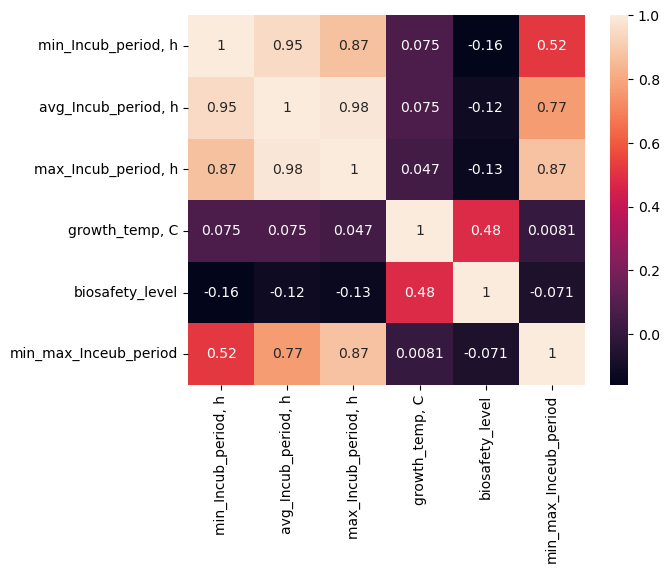

In [7]:
sns.heatmap(df_bac.corr(numeric_only=True), annot=True)

# Мерджим все бд в одну

In [72]:
data_with_bac = pd.merge(df_data, df_bac, left_on='Bacteria', right_on='Bacteria', how='outer')

In [73]:
df = pd.merge(data_with_bac, df_drug, left_on='Drug', right_on='Drug', how='outer')

In [75]:
df.columns

Index(['Bacteria', 'NP_Synthesis', 'Drug', 'Drug_class_drug_bank', 'Drug_dose',
       'NP_concentration', 'NP size_min', 'NP size_max', 'NP size_avg',
       'shape', 'method', 'ZOI_drug', 'ZOI_NP', 'ZOI_drug_NP',
       'fold_increase_in_antibacterial_activity (%)', 'MDR_check', 'kingdom',
       'subkingdom', 'clade', 'phylum', 'class', 'order', 'family', 'genus',
       'species', 'gram', 'min_Incub_period, h', 'avg_Incub_period, h',
       'max_Incub_period, h', 'growth_temp, C', 'biosafety_level',
       'isolated_from', 'Smiles', 'LabuteASA', 'NumHDonors', 'NumHAcceptors',
       'MolLogP', 'Solubility', 'MolWt', 'Chi0'],
      dtype='object')